# Laplacian Smoothing

We solve the Laplacian smoothing problem on data collected from an fMRI experiment.

In [1]:
import scipy.sparse as spsp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk


# We have data in a 2D grid.
data = pd.read_csv('fmri_z.csv')
data = data.values
N = data.shape[0]

## Generate graph for the 2D grid

The graph structure of our data is implicitly given in the 2D grid.

We first have to create an [adjacency matrix for the grid](https://stackoverflow.com/questions/16329403/how-can-you-make-an-adjacency-matrix-which-would-emulate-a-2d-grid).

We use scipy sparse matrix format throughout our graph construction to ensure we exploit sparsity.

In [2]:
def make_A(rows, cols):
    '''
    We first construct an adjacency matrix for the 2D grid (N*N) that we have. 
    The adjacency matrix will be N^2 by n^2.
    We aggregate the nodes of the grid in a row-by-row manner.
    '''
    
    n = rows*cols
    
    # Use lil_matrix to build the matrix, then convert to CSC 
    M = spsp.lil_matrix((n,n))
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            # Two inner diagonals
            if c > 0: 
                M[i-1,i] = M[i,i-1] = 1
            # Two outer diagonals
            if r > 0: 
                M[i-cols,i] = M[i,i-cols] = 1
    return spsp.csc_matrix(M)

A = make_A(N,N)

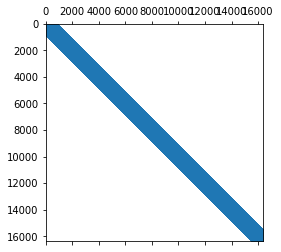

In [3]:
# Let's check out the sparsity pattern
plt.spy(A)
plt.show()

Alright, the matrix is too large and the sparsity pattern is hard to spot.

$A$ is not a banded matrix. There is a sparsity pattern within the band. I'll just move on.

Next, we get the Laplacian.

In [4]:
def make_L(A):
    W = spsp.spdiags(A.sum(1).flatten(), 0, N*N, N*N)
    L = W - A
    return L
L = make_L(A)

## Solve Laplacian Smoothing

Now we got the matrices we need. Let's do the optimization by solving a sparse linear system!

### Sparse Solver from SciPy

In [5]:
def direct_solve(L,lam, y):
    "Scipy sparse linear solver"
    
    NN = y.shape[0]
    I = spsp.identity(NN)
    M = spsp.csc_matrix(lam * L + I)

    return spsp.linalg.spsolve(M, y)

In [6]:
y = data.reshape(N*N,1)
direct = direct_solve(L, 1, y)
direct = direct.reshape(N, N)

### Gauss-Seidel

It's hard to get the dimensions right. Spsp.linalg.spsolve() gives a (X,) vector. We reshape it to (X,1).

In [29]:
def gs_solve(L,lam, y):
    "Solve the smoothing problem with Gauss-Seidel method."

    NN = y.shape[0]
    I = spsp.identity(NN)
    M = spsp.csc_matrix(lam * L + I)

    #Lower and Upper triangular components
    LO = spsp.tril(M, format='csc')
    U = M - LO

    err = 1
    # Initialize our guess as zero
    guess = np.zeros((NN, 1))
    cnt = 1
    while err > 10e-6:
        rhs = y - U.dot(guess)
        
        last = guess.copy()
        guess = spsp.linalg.spsolve(LO, rhs)
        guess = guess.reshape(NN, 1)

        #print(guess.shape)
        #print(y.shape)
        #print(y.flatten().shape)
        err = np.linalg.norm(last - guess, ord = np.inf)
        #print(err)

    return guess

In [30]:
gs = gs_solve(L, 1, y)
gs = gs.reshape(N, N)

## Plots!

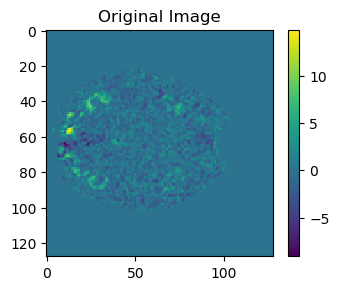

In [83]:
plt.figure(figsize=(4, 3), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(data)
plt.title("Original Image")
plt.colorbar()
plt.show()

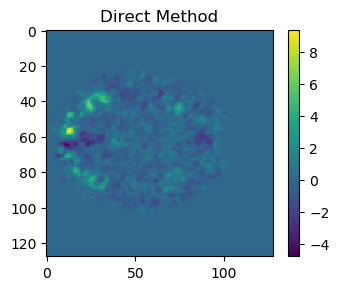

In [89]:
plt.figure(figsize=(4, 3), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(direct)
plt.title("Direct Method")
plt.colorbar()
plt.show()

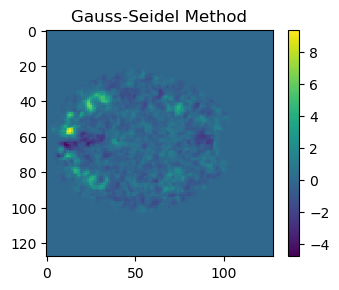

In [28]:
plt.figure(figsize=(4, 3), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(gs)
plt.title("Gauss-Seidel Method")
plt.colorbar()
plt.show()

## Time Consumption

In [35]:
import time

T = 10
t = time.perf_counter()
for i in range(T):
    direct = direct_solve(L, 1, y)
direct_time = (time.perf_counter() - t) / T
print('The CPU time for SciPy sparse solver is: ' + str(direct_time) + ' seconds.')

The CPU time for SciPy sparse solver is: 0.06886682499898597 seconds.


In [37]:
t = time.perf_counter()
for i in range(T):
    gs = gs_solve(L, 1, y)
gs_time = (time.perf_counter() - t) / T
print('The CPU time for Gause-Seidel is: ' + str(gs_time) + ' seconds.')

The CPU time for Gause-Seidel is: 0.8538026351016015 seconds.


In my implementation, the direct solver is much faster than Gauss-Seidel.